# XHEC: Session 5-2  

Explore topic extraction and sentiment analysis existing libraries 

## Import libraries 

In [1]:
import os
os.getcwd()
#os.chdir("path to your drive folder") # path to your drive folder

'c:\\Users\\Dell\\MASTER COURSES\\CapGemini Datacamp\\Session 5'

In [2]:
#!pwd
os.listdir()
#!ls

['corr_1_session_5_LDA.ipynb',
 'ex_1_session_5_LDA.ipynb',
 'ex_2_session_6_LDA_SE.ipynb',
 'LDA_model.pkl',
 'LDA_model.pkl.expElogbeta.npy',
 'LDA_model.pkl.id2word',
 'LDA_model.pkl.state',
 'process.py',
 'requirements_c5.txt',
 'reviews_cleaned.parquet',
 'word_dict.txt',
 '__pycache__']

In [3]:
with open("requirements_c5.txt", "r") as f:
    print(f)


<_io.TextIOWrapper name='requirements_c5.txt' mode='r' encoding='UTF-8'>


In [3]:

import os
import numpy as np
import pandas as pd
import pickle
import operator
from tqdm import tqdm_notebook as tqdm
import nltk
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpor
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import spacy
#!python3 -m spacy download fr_core_news_sm # to run juste one time
#!pip install vaderSentiment

import sys
sys.path.insert(0, './')
import process

%load_ext autoreload
%autoreload 2


Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Load data 

In [5]:
DATASET_SIZE = 30000
def get_reviews(filepath, nrows=None):
    df = pd.read_parquet(filepath)
    if nrows !=None:
      df = df.sample(nrows)
    return df

In [5]:
path = "reviews_cleaned.parquet"
reviews = pd.read_parquet(path)
reviews.shape

(37294, 15)

In [6]:
#TO DO: Check document variable
reviews.head()

,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed
0,0,1,Aucun soucis particulier,Je paie ma facture tous les deux mois en fonct...,Il y a 17 heures,4,None,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,je paie ma facture tous les deux mois en fonct...,"[[je, ], [paie, ], [ma, ], [facture, ], [tous,...","[[je, ], [pai, ], [ma, ], [factur, ], [tous, ]...","[paie, facture, mois, fonction, consommation, ...","[pai, factur, mois, fonction, consomm, exact, ..."
1,1,1,Engie facture a ses clients des sommes…,Engie facture a ses clients des sommes exorbit...,Il y a un jour,1,"Bonjour Julien Blanco,\n\nPour des raisons de ...",Date de l'expérience: 26 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,engie facture a ses clients des sommes exorbit...,"[[engie, ], [facture, ], [a, ], [ses, ], [clie...","[[engi, ], [factur, ], [a, ], [se, ], [client,...","[engie, facture, clients, exorbitants, engie, ...","[engi, factur, client, somm, exorbit, engi, fa..."
2,2,1,Facturation sur consommation d'un autre logement,Ils me facturent sur le pdl du logement au des...,ll y a 3 jours,1,"Bonjour BlooDz,\n\nPour des raisons de confide...",Date de l'expérience: 29 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,ils me facturent sur le pdl du logement au des...,"[[ils, ], [me, ], [facturent, ], [sur, ], [le,...","[[il, ], [me, ], [facturent, ], [sur, ], [le, ...","[facturent, pdl, logement, disant, faute, jama...","[facturent, pdl, log, dis, faut, jam, pris, fa..."
3,3,1,un service client ou il est dur de…,un service client ou il est dur de comprendre ...,ll y a 3 jours,1,"Bonjour Ricanto77,\nPour des raisons de confid...",Date de l'expérience: 29 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,un service client ou il est dur de comprendre ...,"[[un, ], [service, ], [client, ], [ou, ], [il,...","[[un, ], [servic, ], [client, ], [ou, ], [il, ...","[service, client, dur, comprendre, langue, uti...","[servic, client, dur, comprendr, langu, utilis..."
4,4,1,Client d'ENGIE depuis longtemps toujours satis...,Excellente expérience avec ENGIE et une interl...,Il y a 24 minutes,5,None,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,excellente expérience avec engie et une interl...,"[[excellente, ], [expérience, ], [avec, ], [en...","[[excellent, ], [expérient, ], [avec, ], [engi...","[excellente, expérience, engie, interlocutrice...","[excellent, expérient, engi, interlocutric, so..."


In [7]:
reviews.fournisseur.value_counts()

https://www.avis-verifies.com/avis-clients/edfenr.com                        5080
https://fr.trustpilot.com/review/totalenergies.fr                            4980
https://www.avis-verifies.com/avis-clients/engie-homeservices.fr             4450
https://www.avis-verifies.com/avis-clients/totalenergies.fr?filtre=&p=87     3910
https://www.avis-verifies.com/avis-clients/totalenergies.fr                  3820
https://fr.trustpilot.com/review/ilek.fr                                     3120
https://fr.trustpilot.com/review/ohm-energie.com                             2520
https://www.avis-verifies.com/avis-clients/fr.eni.com                        2280
https://www.avis-verifies.com/avis-clients/totalenergies.fr?filtre=&p=478    1650
https://www.avis-verifies.com/avis-clients/happ-e.fr                         1300
https://fr.trustpilot.com/review/engie.fr                                    1160
https://fr.trustpilot.com/review/eni.fr                                       800
https://fr.trust

#### Filter the reviews for TotalEnergies 

In [8]:
reviews = reviews[reviews.fournisseur.str.contains("totalenergies")].reset_index()
reviews.shape

(14360, 16)

In [9]:
### Exemple of preprocessing already done
print(reviews["verbatim"][1])
print('----------')
print(reviews["tokens_lem_processed"][1])
print('----------')
print(reviews["tokens_processed"][1])

Installation Rapide, Prix concurrentiel et surtout promotion de -50€ + 10% de réduction supplémentaire grâce au code 104478135 que j'ai utilisé.

La mise en route a pris 1 semaine, joignable rapidement et facilement par téléphone (même si je préfère par Tchat, ils répondent sous 24H)

Rien à redire au prix actuel de l'électricité ....
----------
['rapid' 'prix' 'concurrentiel' 'promot' 'réduct' 'supplémentair' 'grâc'
 'cod' 'utilis' 'mis' 'rout' 'pris' 'semain' 'joignabl' 'rapid' 'facil'
 'téléphon' 'mêm' 'préfer' 'tchat' 'répondent' 'redir' 'prix' 'actuel'
 'électr']
----------
['rapide' 'prix' 'concurrentiel' 'promotion' 'réduction' 'supplémentaire'
 'grâce' 'code' 'utilisé' 'mise' 'route' 'pris' 'semaine' 'joignable'
 'rapidement' 'facilement' 'téléphone' 'préfère' 'tchat' 'répondent'
 'redire' 'prix' 'actuel' 'électricité']


### Custom Preprocessing

In [233]:
import nltk
import unidecode
import re
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, SnowballStemmer


def clean_sentence(sentence, stopwords=False, lemmatize=False, stemming=False):
    sentence = sentence.lower().strip() #lowercase
    sentence = unidecode.unidecode(sentence) #remove accents from letters
    sentence = re.sub(r'[^a-z0-9\s]', '', sentence) #remove non-alphanumeric characters
    sentence = re.sub(r"\d+", "", sentence) #remove numbers
    sentence = re.sub(r"\s+"," ",sentence) #remove whitespace
    sentence = sentence.rstrip().lstrip() #remove space at the beginning and end if it exists
    sentence = re.split('\s+', sentence)

    if stopwords:
        stop_words = nltk.corpus.stopwords.words("french")
        stop_words = [unidecode.unidecode(stopword) for stopword in stop_words]
        sentence = [word for word in sentence if word not in stop_words]
    
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        sentence = [lemmatizer.lemmatize(word) for word in sentence]
    
    if stemming:
        stemmer = SnowballStemmer("french")
        sentence = [stemmer.stem(word) for word in sentence]

    return " ".join(sentence)

reviews["clean_reviews"] = reviews.verbatim.apply(clean_sentence, stopwords=True)
reviews["clean_reviews_lem"] = reviews.verbatim.apply(clean_sentence, stopwords=True, lemmatize=True)

reviews["tokenized_corpus"] = [re.split('\s+', comment) for comment in reviews.clean_reviews]
reviews["tokenized_corpus_lem"] = [re.split('\s+', comment) for comment in reviews.clean_reviews_lem]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [255]:
#remove accents from default stemmed verbatim
#reviews["tokens_lem_processed"] = [[unidecode.unidecode(i) for i in rev] for rev in reviews.tokens_lem_processed]
reviews["tokens_lem_processed"]

0        [chaqu, contact, téléphon, servic, client, tot...
1        [rapid, prix, concurrentiel, promot, réduct, s...
2        [client, total, énerg, tarif, concurrentiel, c...
3        [somm, litig, somm, demand, énorm, possibl, eu...
4        [démarch, yaich, alor, demand, person, embroui...
                               ...                        
14355    [veux, recevoir, mai, factur, mai, consomm, ch...
14356    [tré, dur, répons, plusieur, compteur, veux, r...
14357    [bjrma, factur, divulgu, voisin, mêm, reçu, du...
14358                            [répons, expliqu, inform]
14359    [satisfait, contact, téléphon, conseil, expliq...
Name: tokens_lem_processed, Length: 14360, dtype: object

#### Date Formatting

In [352]:
dates = pd.DataFrame({"date":reviews.date_experience})
dates["len"] = dates.date.apply(len)
dates.len.unique()
pd.Series([len(i) for i in reviews.date_experience]).value_counts()
#dates.groupby("len").first()

36    7872
37    1611
65    1508
34    1298
38     765
39     553
33     387
35     356
26      10
dtype: int64

In [363]:
dates.date

0         Date de l'expérience: 01 décembre 2022
1         Date de l'expérience: 27 novembre 2022
2         Date de l'expérience: 22 novembre 2022
3         Date de l'expérience: 26 novembre 2022
4        Date de l'expérience: 15 septembre 2022
                          ...                   
14355       suite à une expérience du 05/06/2021
14356       suite à une expérience du 05/06/2021
14357       suite à une expérience du 05/06/2021
14358       suite à une expérience du 05/09/2022
14359       suite à une expérience du 05/09/2022
Name: date, Length: 14360, dtype: object

In [ ]:
import re
from datetime import datetime

df.date[0]

# Define a regex pattern to match dates in the format yyyy-mm-dd
date_pattern = r"\d{4}-\d{2}-\d{2}"

# Find all occurrences of the pattern in the text
matches = re.findall(date_pattern, text)

# Convert each match to a datetime object
dates = [datetime.strptime(match, "%Y-%m-%d").date() for match in matches]

print(dates)

## Topic extraction : LDA  with Gensim


### Preprocessing of reviews to be used by LDA

In [10]:
'''
TO DO : Create a dictionary from 'tokens_lem_processed' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
tokens = reviews.tokens_lem_processed
dictionary = gensim.corpora.Dictionary(tokens)

In [11]:
'''
TO DO : Remove very rare and very common words:
- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [12]:
len(tokens)

14360

In [13]:
'''
TO DO : Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'corpus' (HINT: check dictionary.doc2bow(tokens[0]))
'''
corpus = [dictionary.doc2bow(tok) for tok in tokens]
len(corpus)

14360

In [14]:
'''
Preview BOW for our sample preprocessed document
'''
review_num = 20
bow_doc_x = corpus[review_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 12 ("sach") appears 1 time.
Word 48 ("demand") appears 3 time.
Word 52 ("frais") appears 1 time.
Word 70 ("san") appears 1 time.
Word 82 ("fair") appears 1 time.
Word 87 ("maison") appears 1 time.
Word 96 ("voul") appears 1 time.
Word 210 ("lor") appears 1 time.
Word 214 ("appel") appears 1 time.
Word 262 ("arrivent") appears 1 time.
Word 263 ("arrêt") appears 1 time.
Word 264 ("attend") appears 1 time.
Word 265 ("compteur") appears 2 time.
Word 266 ("convers") appears 1 time.
Word 267 ("coup") appears 1 time.
Word 268 ("enregistr") appears 1 time.
Word 269 ("froid") appears 1 time.
Word 270 ("grand") appears 1 time.
Word 271 ("habit") appears 1 time.
Word 272 ("remettr") appears 1 time.
Word 273 ("remis") appears 1 time.
Word 274 ("sûr") appears 1 time.
Word 275 ("vent") appears 1 time.


### Word2Vec before topic extraction

In [364]:
from gensim.models import Word2Vec
tokenized_corpus = [list(i) for i in reviews.tokens_lem_processed]
w2v = Word2Vec(tokenized_corpus, window=7, min_count=1, workers=5)
w2v.build_vocab(tokenized_corpus)
w2v.train(tokenized_corpus, total_examples=w2v.corpus_count, epochs=100)


(17571022, 20694300)

In [369]:
embedding_matrix = dict()

for word in w2v.wv.index_to_key:
    embedding_matrix[word] = list(w2v.wv[word])

#embedding_matrix = pd.DataFrame(embedding_matrix)

In [372]:
len(embedding_matrix)

7936

In [376]:
def aggregate_review_vectors(reviews, word2vec_model):
    review_vectors = np.zeros((len(reviews), word2vec_model.vector_size))
    #print(review_vectors.shape)
    for i, review_words in enumerate(reviews):
        #review_words = review.split()
        
        review_vector = np.zeros(word2vec_model.vector_size)
        count = 0
        for word in review_words:
            if word in word2vec_model.wv:
                word_vector = word2vec_model.wv[word]
                review_vector += word_vector
                count += 1
        if count > 0:
            review_vector /= count
        #review_vectors.append(review_vector)
        review_vectors[i,:] = review_vector
    return review_vectors


corpus_w2v = aggregate_review_vectors(reviews.tokens_lem_processed, w2v)
len(corpus)

14360

### Train LDA Model

In [15]:
len(corpus), len(dictionary)

(14360, 1375)

In [16]:
#TO DO: build lda model
'''
Train your lda model using gensim.models.ldamodel.LdaModel and save it to 'ldaModel'
'''
nb_topics = 3
alpha = 0.1
eta = 0.1
random_state = 42
np.random.seed(random_state)

ldaModel = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=nb_topics, 
                                           alpha=alpha,
                                           eta=eta,
                                           passes=3,
                                           iterations=200)

In [17]:
ldaModel.show_topics()

[(0,
  '0.022*"appel" + 0.018*"demand" + 0.018*"électr" + 0.017*"jour" + 0.013*"dan" + 0.011*"san" + 0.010*"mêm" + 0.010*"lign" + 0.009*"mois" + 0.009*"rappel"'),
 (1,
  '0.023*"prix" + 0.015*"tarif" + 0.013*"consomm" + 0.013*"fournisseur" + 0.012*"fair" + 0.012*"offre" + 0.009*"énerg" + 0.009*"dan" + 0.009*"person" + 0.008*"autr"'),
 (2,
  '0.034*"facil" + 0.032*"clair" + 0.025*"efficac" + 0.022*"expliqu" + 0.022*"écout" + 0.022*"pass" + 0.020*"merc" + 0.019*"conseil" + 0.019*"person" + 0.019*"simpl"')]

In [392]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value

In [18]:
coherence

NameError: name 'coherence' is not defined

In [279]:
#pyLDAvis visualisation
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldaModel, corpus, dictionary)
vis

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.168492 -0.067556       1        1  48.626830
3      0.081681 -0.053482       2        1  21.683574
1     -0.221034 -0.100460       3        1  17.652757
2     -0.029138  0.221499       4        1  12.036839, topic_info=       Term         Freq        Total Category  logprob  loglift
18    facil  1340.000000  1340.000000  Default  30.0000  30.0000
10   person  1360.000000  1360.000000  Default  29.0000  29.0000
24     prix  1054.000000  1054.000000  Default  28.0000  28.0000
209   clair  1131.000000  1131.000000  Default  27.0000  27.0000
365   écout   706.000000   706.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
48   demand   238.810763  2008.507867   Topic4  -4.4459  -0.0123
47      dan   214.728045  1728.696843   Topic4  -4.5522   0.0314
23     pris   149.507559   673.152534   Topic4  -4.9142   0.6126
209   clair   143.275804  1131.343796   Topic4  -4.9568   0.0508
76    énerg   138.777081  1395.300437   Topic4  -4.9887  -0.1908

[326 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1353      4  0.996285     absent
861       3  0.975988    acceuil
728       3  0.998326  accompagn
276       2  0.059733    accueil
276       3  0.940008    accueil
...     ...       ...        ...
76        3  0.300294      énerg
76        4  0.099620      énerg
842       2  0.967675      énerv
1259      1  0.045520      évolu
1259      4  0.933151      évolu

[612 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [19]:
#TO DO (optional): You can save your model in a pickle
ldaModel.save("LDA_model.pkl")
#pickle.dump(ldaModel, "LDA_model.pkl")

### BONUS : How to choose the good number of topics for LDA

In [399]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=nb_topics, 
                                           alpha=alpha,
                                           eta=eta)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [400]:
## It will take a while to run ( around 15min)
limit=10; start=3; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=reviews.tokens_lem_processed.values, start=start, limit=limit, step=step)

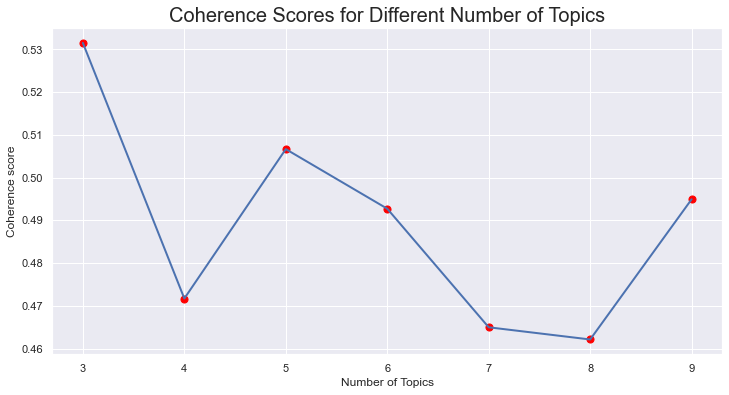

In [421]:
# Show graph
x = range(start, limit, step)
sns.set(rc={'figure.figsize':(12,6)})

for i, c in zip(x, coherence_values):
    plt.scatter(i, c, alpha=1, color="red", s=200, marker=".")

plt.plot(x, coherence_values, linewidth=2)
plt.title("Coherence Scores for Different Number of Topics", fontsize=20)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")


#plt.legend(("coherence_values"), loc='best')
plt.show()

In [25]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4473
Num Topics = 4  has Coherence Value of 0.4864
Num Topics = 5  has Coherence Value of 0.5075
Num Topics = 6  has Coherence Value of 0.4347
Num Topics = 7  has Coherence Value of 0.5172


In [54]:
### Analyze Final Model
#idx = np.array(coherence_values).argmax()
final_model = ldaModel
doc_topics = list(final_model.get_document_topics(corpus))


In [55]:
len(doc_topics), len(reviews)

(14360, 14360)

In [56]:
topics = []
for doc in doc_topics:
    idx = np.array([i[1] for i in doc]).argmax()
    topics.append(doc[idx][0]) 

#count of the topics of documents.
#Topic 6 is the most common with 6269 documents having it as the predominant topic
pd.Series(topics).value_counts() 

2    5605
0    5417
1    3338
dtype: int64

In [44]:
ldaModel.show_topics()

[(0,
  '0.022*"appel" + 0.018*"demand" + 0.018*"électr" + 0.017*"jour" + 0.013*"dan" + 0.011*"san" + 0.010*"mêm" + 0.010*"lign" + 0.009*"mois" + 0.009*"rappel"'),
 (1,
  '0.023*"prix" + 0.015*"tarif" + 0.013*"consomm" + 0.013*"fournisseur" + 0.012*"fair" + 0.012*"offre" + 0.009*"énerg" + 0.009*"dan" + 0.009*"person" + 0.008*"autr"'),
 (2,
  '0.034*"facil" + 0.032*"clair" + 0.025*"efficac" + 0.022*"expliqu" + 0.022*"écout" + 0.022*"pass" + 0.020*"merc" + 0.019*"conseil" + 0.019*"person" + 0.019*"simpl"')]

In [45]:
top_topics_ = ldaModel.top_topics(corpus)
top_topics_[0]

([(0.021639163, 'appel'),
  (0.01786452, 'demand'),
  (0.017643178, 'électr'),
  (0.01726453, 'jour'),
  (0.012853517, 'dan'),
  (0.011062203, 'san'),
  (0.009884047, 'mêm'),
  (0.009524126, 'lign'),
  (0.009453151, 'mois'),
  (0.009389266, 'rappel'),
  (0.00916968, 'pai'),
  (0.008881462, 'alor'),
  (0.00873807, 'compteur'),
  (0.008551845, 'toujour'),
  (0.008324334, 'compt'),
  (0.008035194, 'fair'),
  (0.007388801, 'mail'),
  (0.0069286847, 'mis'),
  (0.0063371025, 'activ'),
  (0.0062855957, 'énerg')],
 -1.7719796739615865)

In [33]:
model_list

In [46]:
optimal_model = ldaModel
#optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(0,
  '0.022*"appel" + 0.018*"demand" + 0.018*"électr" + 0.017*"jour" + '
  '0.013*"dan" + 0.011*"san" + 0.010*"mêm" + 0.010*"lign" + 0.009*"mois" + '
  '0.009*"rappel" + 0.009*"pai" + 0.009*"alor" + 0.009*"compteur" + '
  '0.009*"toujour" + 0.008*"compt" + 0.008*"fair" + 0.007*"mail" + 0.007*"mis" '
  '+ 0.006*"activ" + 0.006*"énerg"'),
 (1,
  '0.023*"prix" + 0.015*"tarif" + 0.013*"consomm" + 0.013*"fournisseur" + '
  '0.012*"fair" + 0.012*"offre" + 0.009*"énerg" + 0.009*"dan" + 0.009*"person" '
  '+ 0.008*"autr" + 0.008*"abon" + 0.008*"temp" + 0.007*"électr" + 0.007*"mêm" '
  '+ 0.007*"ras" + 0.007*"totalenerg" + 0.007*"san" + 0.007*"gaz" + '
  '0.007*"parl" + 0.006*"augment"'),
 (2,
  '0.034*"facil" + 0.032*"clair" + 0.025*"efficac" + 0.022*"expliqu" + '
  '0.022*"écout" + 0.022*"pass" + 0.020*"merc" + 0.019*"conseil" + '
  '0.019*"person" + 0.019*"simpl" + 0.017*"accueil" + 0.015*"satisf" + '
  '0.014*"agréabl" + 0.014*"tre" + 0.013*"inscript" + 0.012*"contact" + '
  '0.011*"profe

## Sentiment analysis 

In [35]:
!pip install textblob_fr vaderSentiment-fr --no-cache-dir

In [20]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer


Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


### Vader 

In [96]:
def visualise_sentiments(data):
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")
  
sns.set(rc={'figure.figsize':(30,1)})

In [97]:
reviews.head(1)

,index,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed,sentiment,topics,sent
0,5000,5000,1,Service impeccable chez Total Energie,A chaque fois que je contacte au téléphone le ...,Il y a 19 heures,5,None,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/totalenergies.fr,trustpilot,a chaque fois que je contacte au téléphone le ...,"[[a, ], [chaque, ], [fois, ], [que, ], [je, ],...","[[a, ], [chaqu, ], [fois, ], [que, ], [je, ], ...","[contacte, téléphone, service, clients, total,...","[chaqu, contact, téléphon, servic, client, tot...",1,2,0


In [119]:
#TO DO: visualise sentiment  of different sentence of reviews and comprae Vader vs TextBlob

raw = reviews.sample(1) # sample one raw from reviews dataframe,raw = reviews.sample()


sentence = " ".join(raw.tokens_processed.values[0])

print('============Verbatim : ============')
print(raw.verbatim.values[0])

print('=============cleand verbatim : ===========')
print(sentence)

============Verbatim : ============
J'ai eu une interlocutrice très gentille, très compréhensive, qui a répondu à toutes mes questions, et qui m'a proposé une formule beaucoup plus intéressante que celle que j'avais jusqu'alors. Je suis pour l'instant ravie du professionnalisme et de l'écoute que j'ai eu.
=============cleand verbatim : ===========
interlocutrice gentille compréhensive répondu questions proposé formule intéressante instant ravie professionnalisme écoute


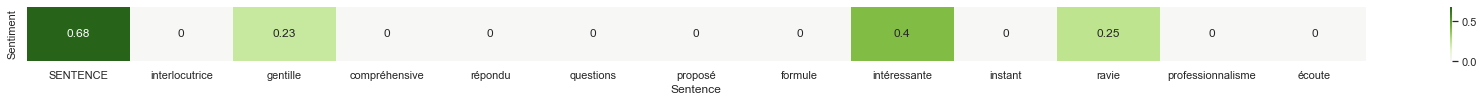

In [123]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)


visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sid.polarity_scores(sentence)["compound"]] + [sid.polarity_scores(word)["compound"] for word in sentence.split()]
})



## TextBlob

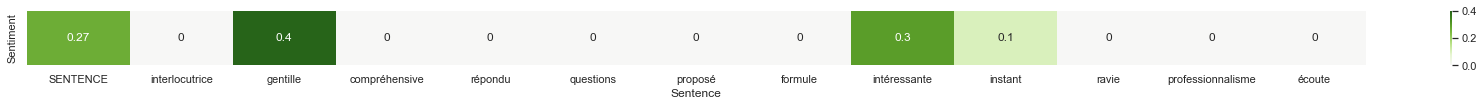

In [121]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[tb(sentence).sentiment[0]] + [tb(word).sentiment[0] for word in sentence.split()]
})

In [103]:
def vader_sentiment_scores(sentence):
    sentence = " ".join(sentence)
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # decide sentiment as positive, negative and neutral
    #vader has an option for neutral but in our case its just positive/negative so we fix it to be this way.
    if sentiment_dict['compound'] > -0.05 :
        return 1
    else:
        return 0

def text_blob_sentiment_score(text):
  sentence = " ".join(text)
  s= TextBlob(sentence).sentiment.polarity

  if s > -0.05 :
    return 1
  else:
    return 0


In [104]:
#samp = reviews.head(1000)
reviews["sentiment"] = np.where(reviews['note']>=4, 1, 0)
pos_reviews = reviews[reviews.sentiment == 1].head(500)
neg_reviews = reviews[reviews.sentiment == 0].head(500)
samp = pd.concat([pos_reviews,neg_reviews])
samp.sentiment.value_counts()

1    500
0    500
Name: sentiment, dtype: int64

In [106]:
vader_pred = reviews.tokens_processed.apply(vader_sentiment_scores)

In [107]:
textBlob_pred = reviews.tokens_processed.apply(text_blob_sentiment_score)

In [25]:
from sklearn.metrics import f1_score, accuracy_score


In [291]:
print(f'F1 score for vader : {f1_score(vader_pred, samp.sentiment)}')
print(f'F1 score for TextBlob : {f1_score(textBlob_pred, samp.sentiment)}')

F1 score for vader : 0.7678122380553226
F1 score for TextBlob : 0.7014820042342979


### Rating vs sentiment

In [26]:
## TO DO : Explore your dataset
print(reviews.shape)
reviews.head(3)

(14360, 16)


,index,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed
0,5000,5000,1,Service impeccable chez Total Energie,A chaque fois que je contacte au téléphone le ...,Il y a 19 heures,5,None,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/totalenergies.fr,trustpilot,a chaque fois que je contacte au téléphone le ...,"[[a, ], [chaque, ], [fois, ], [que, ], [je, ],...","[[a, ], [chaqu, ], [fois, ], [que, ], [je, ], ...","[contacte, téléphone, service, clients, total,...","[chaqu, contact, téléphon, servic, client, tot..."
1,5001,5001,1,Offre immanquable,"Installation Rapide, Prix concurrentiel et sur...",ll y a 5 jours,5,None,Date de l'expérience: 27 novembre 2022,https://fr.trustpilot.com/review/totalenergies.fr,trustpilot,installation rapide prix concurrentiel et surt...,"[[installation, MISC], [rapide, ], [prix, ], [...","[[rapid, ], [prix, ], [concurrentiel, ], [et, ...","[rapide, prix, concurrentiel, promotion, réduc...","[rapid, prix, concurrentiel, promot, réduct, s..."
2,5002,5002,1,Service client déplorable,Cliente chez total énergie depuis près de deux...,Il y a un jour,1,"Bonjour Monsieur, Madame,\n\nJ'ai bien pris en...",Date de l'expérience: 22 novembre 2022,https://fr.trustpilot.com/review/totalenergies.fr,trustpilot,cliente chez total énergie depuis près de deux...,"[[cliente, ], [chez, ], [total, ], [énergie, ]...","[[client, ], [chez, ], [total, ], [énerg, ], [...","[cliente, total, énergie, ans, tarifs, concurr...","[client, total, énerg, tarif, concurrentiel, c..."


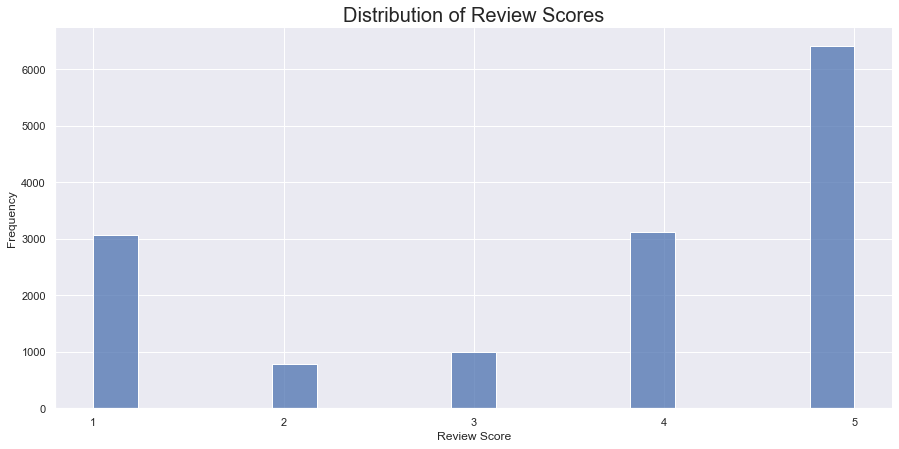

In [343]:
plt.figure(figsize = (15,7))
#reviews.note.plot.hist()
ax = sns.histplot(reviews.note)
ax.set_title('Distribution of Review Scores', fontdict={'fontsize': 20, 'fontfamily': 'Arial'})
ax.set_xlabel('Review Score')
ax.set_ylabel('Frequency')
ax.set_xticks(range(1, 6))


sns.despine()


In [27]:
## TO DO : by using a threshold between 14 an 16, identifiy positif reviews and not positif reviews
reviews['sentiment'] = np.where(reviews['note']>=4, "pos", "not_pos")           

### Preprocessing

In [61]:
#reviews = reviews[reviews['clean_verb']!=""]

In [114]:
reviews.head(3)

,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed,sentiment
0,0,1,Aucun soucis particulier,Je paie ma facture tous les deux mois en fonct...,Il y a 17 heures,4,None,Date de l'expérience: 01 décembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,je paie ma facture tous les deux mois en fonct...,"[[je, ], [paie, ], [ma, ], [facture, ], [tous,...","[[je, ], [pai, ], [ma, ], [factur, ], [tous, ]...","[paie, facture, mois, fonction, consommation, ...","[pai, factur, mois, fonction, consomm, exact, ...",pos
1,1,1,Engie facture a ses clients des sommes…,Engie facture a ses clients des sommes exorbit...,Il y a un jour,1,"Bonjour Julien Blanco,\n\nPour des raisons de ...",Date de l'expérience: 26 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,engie facture a ses clients des sommes exorbit...,"[[engie, ], [facture, ], [a, ], [ses, ], [clie...","[[engi, ], [factur, ], [a, ], [se, ], [client,...","[engie, facture, clients, exorbitants, engie, ...","[engi, factur, client, somm, exorbit, engi, fa...",not_pos
2,2,1,Facturation sur consommation d'un autre logement,Ils me facturent sur le pdl du logement au des...,ll y a 3 jours,1,"Bonjour BlooDz,\n\nPour des raisons de confide...",Date de l'expérience: 29 novembre 2022,https://fr.trustpilot.com/review/engie.fr,trustpilot,ils me facturent sur le pdl du logement au des...,"[[ils, ], [me, ], [facturent, ], [sur, ], [le,...","[[il, ], [me, ], [facturent, ], [sur, ], [le, ...","[facturent, pdl, logement, disant, faute, jama...","[facturent, pdl, log, dis, faut, jam, pris, fa...",not_pos


In [28]:
# TO DO : number of positif / negatif comment 
print(reviews.sentiment.value_counts())
ratio = len(reviews[reviews.sentiment=="pos"]) / len(reviews[reviews.sentiment=="not_pos"])
print(f"Ratio of positive comments over negative comments: {ratio}")

pos        9528
not_pos    4832
Name: sentiment, dtype: int64
Ratio of positive comments over negative comments: 1.9718543046357615


In [29]:
len(reviews[reviews.sentiment=="pos"])/ len(reviews)

0.6635097493036212

In [30]:
#Mean rating of positive sentiment comments vs negative sentiment comments

reviews.groupby("sentiment")["note"].mean()

sentiment
not_pos    1.570157
pos        4.672859
Name: note, dtype: float64

## Vectorization with tfidf

In [31]:
data = reviews.copy()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


docs = data.tokens_processed.map(lambda tokens: " ".join(tokens))

min_df = .01
max_df = 0.99

vectorizer = TfidfVectorizer(min_df=min_df,
                             max_df=max_df,
                             analyzer="word",
                             ngram_range=(1,2))

X = vectorizer.fit_transform(docs)
# os.mkdir("output/")
#pickle.dump(vectorizer, open(os.path.join("./output", f"vectorizer_avis.pkl"), "wb"))

y = np.where(data["sentiment"] == "pos", 1, 0)
print(X.shape, y.shape)


(14360, 225) (14360,)


**what is the importance of the parmeters min_df and max_df** ?

It's the frequency of words that appear which we want to ignore. So any words over the max_df and below the min_df threshold will be neglected. This is important as words that appear in every single sentence is not important and the same for words that appear too little.

In [32]:
### Se the tfidf matrix
column = np.array(vectorizer.get_feature_names_out())
df_tfidf = pd.DataFrame(X.todense(), columns = column)
print(df_tfidf.shape)
df_tfidf.head()

(14360, 225)


,abonnement,accueil,agréable,aimable,ancien,année,ans,appartement,appel,appeler,...,téléphone,téléphonique,viens,vite,voir,voleurs,vraiment,écoute,électricité,énergie
0,0.000000,0.0,0.341832,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.255156,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.240023,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.240939,0.000000
2,0.261888,0.0,0.000000,0.0,0.0,0.000000,0.141678,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.297514
3,0.000000,0.0,0.000000,0.0,0.0,0.326824,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.285676,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


## Train a Logistic Regression Classifier

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [36]:
classifier = LogisticRegression(class_weight = 'balanced', random_state=2023 )

# Train test split with classes stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=2023)

model = classifier.fit(X_train, y_train) # fit your model
yhat = model.predict(X_test)  # predict in test data

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1450
           1       0.90      0.86      0.88      2858

    accuracy                           0.84      4308
   macro avg       0.82      0.83      0.83      4308
weighted avg       0.84      0.84      0.84      4308



## Explain the  review’s sentiment 

We can use [SHAP](https://shap.readthedocs.io/en/latest/index.html) to explain our model. 

In the following graphique **Feature Value** refers to  the frequence of the word in the reviews. So in the plots below the positive features are actually helping raise the chance of a positive review, while the negative features are lowering the chance. It is interesting to see how what is not present in the text  is often just as important as what is in the text. Remember the values of the features are TF-IDF values.



The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


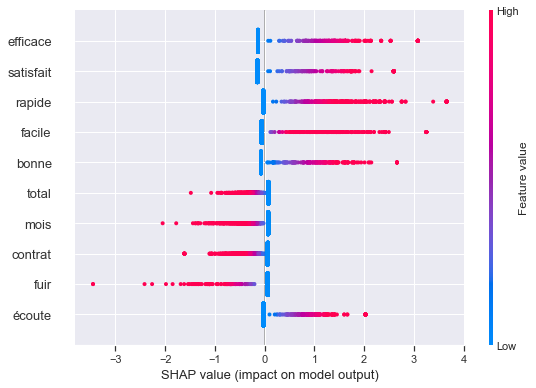

In [37]:
import shap

explainer = shap.LinearExplainer(
    model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
# we need to pass a dense version for the plotting functions
X_test_array = X_test.toarray()

shap.summary_plot(shap_values, X_test_array,
            feature_names=vectorizer.get_feature_names_out(), max_display=10)

Word like **rapide**, **professionnel**, **efficace**, **facture**, **écoute** ... are associated to negative comments.

## Prediction

define first a pipline to pre-process a text input and apply the vectoriser 

In [34]:
def join_tok(tokens):
    return [' '.join(tokens)]
    
Pipeline = {'tokenize': process.tokenize_stemme,
            'clean_token': process.clean_tokens,
            'join' : join_tok,
            'tfidf' : vectorizer.transform,
           
          }

def DetectSentiment(text, model):
  for func in Pipeline:
      text = Pipeline[func](text)
      
  return model.predict_proba(text)[0][1] # score of the positive classe

In [62]:
!python -m spacy download fr_core_news_sm

✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [38]:
text = "Je suis très déçu par les services offerts par Total Energie. J'ai trouvé leur service clientèle\
        désorganisé et leur manque de communication a été très décevant. Je ne recommanderais pas Total Energie à mes amis."

DetectSentiment(text, model)

0.69590745742044

In [64]:
# TO DO : 


# 0 - Using documentations, what is the diffrence between Vader and textBlob ? Do they calculate the scores in the same way ?
# 1 -  Compare the performence between vader and the Logistique regression classifier.

## HINT : 
#       - Separate negative reviews and positif reviews
#       - Compare Logistic regression's scores  and vader's scores in each group

# 2 -  Use a Decision Tree classier instead of Logistique regression. Do you have better results ?
# 3 -  Use an embedding approach instead of tfifd. Do you have better results ?


Vader (Valence Aware Dictionary and sEntiment Reasoner) uses a lexicon-based approach to sentiment analysis. It uses a pre-built list of words and phrases that have been previously labeled with sentiment scores and applies rules to calculate the overall sentiment score of a text. Vader also takes into account the intensity of sentiment and negations in the text.

TextBlob, on the other hand, uses a rule-based approach to sentiment analysis. It uses a machine learning algorithm to learn patterns from a labeled dataset of text and applies these patterns to new text to determine its sentiment score.

In [108]:
# 1 -  Compare the performence between vader and the Logistique regression classifier.

#Logistic Regression
print(f"Logistic Regression Accuracy: {f1_score(yhat, y_test)}")

#VaderPred
#vader_pred = reviews.tokens_processed.apply(vader_sentiment_scores)
print(f"Vader Accuracy: {f1_score(vader_pred, reviews.sentiment)}")




Logistic Regression Accuracy: 0.9381040509973266
Vader Accuracy: 0.8379560640292266


In [110]:
pos_idx = np.where(y_test == 1)
neg_idx = np.where(y_test == 0)

print("Logistic Regression")
print(f"Accuracy % for positive predictions: {np.mean(y_test[pos_idx] == yhat[pos_idx])}")
print(f"Accuracy % for negative predictions: {np.mean(y_test[neg_idx] == yhat[neg_idx])}\n\n")

y_samp = reviews.sentiment.ravel()
pos_idx = np.where(y_samp == 1)
neg_idx = np.where(y_samp == 0)
print("Vader")
print(f"Accuracy % for positive predictions: {np.mean(vader_pred.ravel()[pos_idx] == y_samp[pos_idx])}")
print(f"Accuracy % for negative predictions: {np.mean(vader_pred.ravel()[neg_idx] == y_samp[neg_idx])}\n\n")

print("TextBlob")
print(f"Accuracy % for positive predictions: {np.mean(textBlob_pred.ravel()[pos_idx] == y_samp[pos_idx])}")
print(f"Accuracy % for negative predictions: {np.mean(textBlob_pred.ravel()[neg_idx] == y_samp[neg_idx])}\n\n")




Logistic Regression
Accuracy % for positive predictions: 0.9575986565910999
Accuracy % for negative predictions: 0.8344370860927153


Vader
Accuracy % for positive predictions: 0.9147774979009236
Accuracy % for negative predictions: 0.47040562913907286


TextBlob
Accuracy % for positive predictions: 0.9943324937027708
Accuracy % for negative predictions: 0.10347682119205298




In [100]:
y.shape

(14334,)

In [112]:
#3
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(f"Decision Tree Accuracy: {f1_score(yhat, y_test)}")

pos_idx = np.where(y_test == 1)
neg_idx = np.where(y_test == 0)

print(f"Accuracy % for positive predictions: {np.mean(yhat.ravel()[pos_idx] == y_test[pos_idx])}")
print(f"Accuracy % for negative predictions: {np.mean(yhat.ravel()[neg_idx] == y_test[neg_idx])}")

Decision Tree Accuracy: 0.8954412379757424
Accuracy % for positive predictions: 0.8988245172124265
Accuracy % for negative predictions: 0.7855960264900662


In [113]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(f"Gradient Booster Accuracy: {f1_score(yhat, y_test)}")

print(f"Accuracy % for positive predictions: {np.mean(yhat.ravel()[pos_idx] == y_test[pos_idx])}")
print(f"Accuracy % for negative predictions: {np.mean(yhat.ravel()[neg_idx] == y_test[neg_idx])}")


Gradient Booster Accuracy: 0.9160997732426305
Accuracy % for positive predictions: 0.9328295549958019
Accuracy % for negative predictions: 0.7955298013245033


In [114]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(f"Random Forest Accuracy: {f1_score(yhat, y_test)}")

print(f"Accuracy % for positive predictions: {np.mean(yhat.ravel()[pos_idx] == y_test[pos_idx])}")
print(f"Accuracy % for negative predictions: {np.mean(yhat.ravel()[neg_idx] == y_test[neg_idx])}")


Random Forest Accuracy: 0.9379225568531039
Accuracy % for positive predictions: 0.9609571788413098
Accuracy % for negative predictions: 0.8261589403973509


We already have the labels. What is the point for the model? We say that we built a model that is readily usable for future predictions.

### Word2Vec

In [44]:
#4: Word embedding with our own data
from gensim.models import Word2Vec
tokenized_corpus = [list(i) for i in reviews.tokens_lem_processed]
w2v = Word2Vec(tokenized_corpus, window=7, min_count=1, workers=5)
w2v.build_vocab(tokenized_corpus)
w2v.train(tokenized_corpus, total_examples=w2v.corpus_count, epochs=100)


(17572126, 20694300)

In [45]:
w2v.corpus_count

14360

In [46]:
embedding_matrix = dict()

for word in w2v.wv.index_to_key:
    embedding_matrix[word] = list(w2v.wv[word])

embedding_matrix = pd.DataFrame(embedding_matrix)

In [47]:
def aggregate_review_vectors(reviews, word2vec_model):
    review_vectors = np.zeros((len(reviews), word2vec_model.vector_size))
    #print(review_vectors.shape)
    for i, review_words in enumerate(reviews):
        #review_words = review.split()
        
        review_vector = np.zeros(word2vec_model.vector_size)
        count = 0
        for word in review_words:
            if word in word2vec_model.wv:
                word_vector = word2vec_model.wv[word]
                review_vector += word_vector
                count += 1
        if count > 0:
            review_vector /= count
        #review_vectors.append(review_vector)
        review_vectors[i,:] = review_vector
    return review_vectors


X = aggregate_review_vectors(reviews.tokens_lem_processed, w2v)
y = np.where(reviews.note >= 4, 1, 0)
X.shape, y.shape

((14360, 100), (14360,))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=31)

In [50]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(f"Random Forest Accuracy: {f1_score(yhat, y_test)}")


pos_idx = np.where(y_test == 1)
neg_idx = np.where(y_test == 0)
print(f"Accuracy % for positive predictions: {np.mean(yhat.ravel()[pos_idx] == y_test[pos_idx])}")
print(f"Accuracy % for negative predictions: {np.mean(yhat.ravel()[neg_idx] == y_test[neg_idx])}")

Random Forest Accuracy: 0.9381040509973266
Accuracy % for positive predictions: 0.9575986565910999
Accuracy % for negative predictions: 0.8344370860927153


In [57]:
reviews["topics"] = topics

In [94]:
mean_by_topic = pd.DataFrame(reviews.groupby("topics")["note"].mean())
mean_by_topic["sentiment"] = reviews.groupby("topics")["sentiment"].mean()

mean_by_topic = mean_by_topic.rename(
    index={0:"Customer Service", 1:"Price", 2:"Other"})
mean_by_topic.to_excel("topic_and_sentiment_.xlsx")

In [65]:
reviews.sentiment.value_counts()

1    9528
0    4832
Name: sentiment, dtype: int64

In [66]:
reviews["sent"] = np.where(reviews.sentiment == "pos", 1, 0)
reviews.groupby("topics")["sentiment"].mean()

topics
0    0.367362
1    0.653685
2    0.955575
Name: sentiment, dtype: float64

### BERT Approach


In [182]:
import transformers as ppb
import tensorflow as tf

# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [196]:
# Apply tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', char_level=False)
tokenizer.fit_on_texts(reviews.clean_reviews)

sequences = tokenizer.texts_to_sequences(reviews.clean_reviews)
print(reviews["tokens_processed"][0], sequences[0], sep="\n\n")
print("\n\n\n")
print(len(reviews["tokens_processed"][0]), len(sequences[0]), sep=" ")

['contacte' 'téléphone' 'service' 'clients' 'total' 'energie' 'gaz'
 'tombe' 'agréable' 'courtoise' 'sachant' 'conseiller' 'recommande'
 'bénéficier' 'tarifs' 'préférentiels']

[142, 35, 183, 21, 4, 91, 6, 8, 33, 75, 582, 34, 129, 1324, 80, 536, 3, 57, 1, 1056, 95, 61, 16, 464, 117, 8837, 282, 951]




16 28


In [206]:
(np.array([len(i) for i in padded]) == 465).all()
max_len

465

In [205]:
max_len = 0
for i in sequences:
    if len(i) > max_len:
        max_len = len(i)

padded = [token + [0] * (max_len - len(token)) for token in sequences]
print(padded[0])


#check if all sizes are equal to max_len
print(pd.Series(([len(pad) for pad in padded]) == max_len).all())

padded = np.array(padded)
print(padded.shape)

[142, 35, 183, 21, 4, 91, 6, 8, 33, 75, 582, 34, 129, 1324, 80, 536, 3, 57, 1, 1056, 95, 61, 16, 464, 117, 8837, 282, 951, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [207]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(14360, 465)

In [208]:
max(tokenizer.index_word.keys())

15725

In [210]:
import torch

input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

RuntimeError: [enforce fail at C:\b\abs_bao0hdcrdh\croot\pytorch_1675190257512\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 20512972800 bytes.

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels = samp.sentiment

features.shape, labels.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels)